In [63]:
# This notebook is temporary and has not been thoroughly tested. It is intended to organize the TCGA-GBM dataset according to the WHO 2021 classification guidelines for CNS tumors
import numpy as np
import pandas as pd
import os
import argparse

import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from scipy.stats import pearsonr, linregress

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

def autopct_format(values):
    def my_format(pct):
        absolute = round(pct / 100. * sum(values))
        return f"{absolute} ({pct:.1f}%)"
    return my_format

# We inspect the full clinical sample, without filters

In [23]:
stream_th = 0
figs_folder = f"Demographics-All"
os.makedirs("../Figures/TDMaps_Grade-IV/"+figs_folder, exist_ok=True)
daysXmonth = 30

TDstats = pd.read_csv(f"../Figures/TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv")
morphology = pd.read_csv(f"../Figures/TDMaps_Grade-IV/demographics-morphology_mask-tissues.csv")

print(TDstats["1-dead 0-alive"].value_counts().sum())
censored = (TDstats["1-dead 0-alive"]==0).sum()
all = TDstats["1-dead 0-alive"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all,2)}%")

396
Precentage of censoring: 42.17%


In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
TDstats["Sex"].value_counts().plot.pie(labels=["Male", "Female"], ax=ax, explode=[0, 0.1], autopct=autopct_format(TDstats["Sex"].value_counts()), colors=['turquoise', 'yellowgreen'])
ax.set_title("Sex", fontweight='bold')
ax.set_ylabel("")
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/sex.svg", dpi=300, format='svg')
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'yellowgreen']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, S in enumerate(["M", "F"]):
    sex = TDstats[TDstats["Sex"]==S]
    mask = ~np.isnan(sex["1-dead 0-alive"]) & ~np.isnan(sex["OS"])
    sex = sex[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((sex["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                sex["1-dead 0-alive"]==1, sex["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in sex.loc[sex["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(sex["1-dead 0-alive"]==1, sex["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in sex["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/sex_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

/tmp/ipykernel_993335/278403268.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)


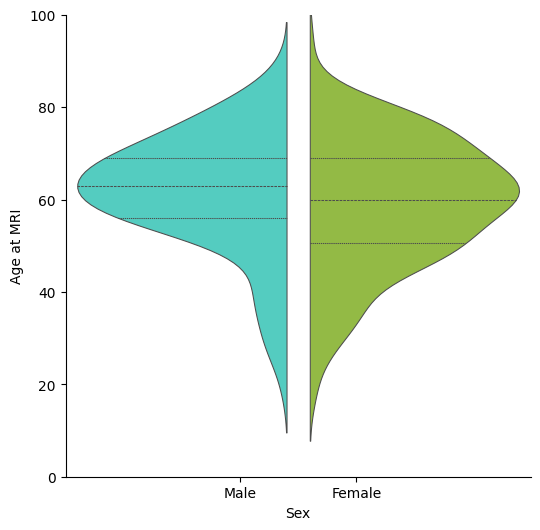

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)
ax.spines[["top","right"]].set_visible(False)
ax.set_ylim([0,100])
ax.set_ylabel("Age at MRI")
ax.set_xticks([0.25, 0.75], ["Male", "Female"])  
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/age-sex.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
dt = TDstats["Final pathologic diagnosis (WHO 2021)"].value_counts()
color_types = [ "indianred", "cadetblue"]
dt.plot.pie(
            ax=ax[0],
            labels=["Glioblastoma IDH-wildtype", "Astrocytoma IDH-mutant"],
            autopct=autopct_format(TDstats["Final pathologic diagnosis (WHO 2021)"].value_counts()),
            colors=color_types,
            explode=[0, 0.1],
            startangle=35
        )
ax[0].set_title("Diagnosis (WHO 2021)", fontweight='bold')
ax[0].set_ylabel("")

dt = TDstats["MGMT status"].fillna("Unknown").value_counts()

# Define updated color palette and labels, including "Unknown"
color_types = ["skyblue", "plum", "khaki", "lightgreen"]
labels = ["Positive", "Negative", "Unknown", "Indeterminate"]

# Create pie plot with updated data
dt.plot.pie(
    ax=ax[1],
    labels=labels,
    autopct=autopct_format(dt),  # Apply formatting function to include absolute counts
    colors=color_types,
    explode=[0.1, 0.1, 0.2, 0.25],  # Set explode for each category
    startangle=180
)

# Customize plot appearance
ax[1].set_title("MGMT Status", fontweight='bold')
ax[1].set_ylabel("")
fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/diagnosis-MGMT.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ["indianred", "cadetblue"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["Glioblastoma  IDH-wildtype", "Astrocytoma  IDH-mutant"]):
    diag = TDstats[TDstats["Final pathologic diagnosis (WHO 2021)"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/diagnosis_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ["skyblue", "plum"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["positive", "negative"]):
    diag = TDstats[TDstats["MGMT status"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMTstatus_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

In [27]:
# Count the values and fill NaN with "Unknown"
mgmt_index_counts = TDstats["MGMT index"].fillna("-1").value_counts()

# Sort the indices based on the original 'MGMT index' values
sorted_index = np.sort(mgmt_index_counts.index.to_numpy(dtype=int))

# Plot a barplot with the sorted order
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    sorted_index,
    mgmt_index_counts[np.argsort(mgmt_index_counts.index.to_numpy(dtype=int))],
    edgecolor="black",
    color=["salmon" if ii==0 else 'lightgray' for ii in range(len(sorted_index))]
)
# Add titles and labels
ax.spines[["top","right"]].set_visible(False)
ax.set_title('MGMT Index', fontweight='bold', fontsize=14)
ax.set_xticks(sorted_index)
ax.set_xticklabels(["N.D."]+[str(ii) for ii in sorted_index[1:]])
ax.set_xlabel('MGMT Index', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines['bottom'].set_bounds(-1.4,17.4)

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout for better display
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

/tmp/ipykernel_993335/1520474872.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mgmt_index_counts[np.argsort(mgmt_index_counts.index.to_numpy(dtype=int))],


In [28]:
# Filter the data
filtered_data = TDstats.dropna(subset=["OS", "MGMT index"])  # Remove rows with NaN in OS or MGMT index
filtered_data = filtered_data[filtered_data["1-dead 0-alive"] == 1]  # Only consider status == 1

# Calculate Pearson correlation
mgmt_index = filtered_data["MGMT index"]
ovs = filtered_data["OS"]
pearson_corr, p_value = pearsonr(mgmt_index, ovs)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    x=mgmt_index,
    y=ovs,
    ax=ax,
    color="blue",
    edgecolor="black",
    alpha=0.8
)

# Add the regression line
sns.regplot(
    x=mgmt_index,
    y=ovs,
    ax=ax,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

# Annotate Pearson correlation
ax.text(
    0.05, 0.95,
    r'$\rho$'+f" = {pearson_corr:.2f} (p = {p_value:.2g})",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.1), 
    color="red" if p_value<=0.05 else "black"
)

# Customize the plot
ax.set_xticks(sorted_index[1:])
ax.set_xlabel("MGMT Index", fontsize=12)
ax.set_ylabel("Overall Survival (Days)", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

# Show the plot
plt.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index_OS.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

EOR                     GTR   STR  biopsy
1p/19q                                   
intact                192.0  78.0    32.0
relative co-deletion    1.0   1.0     NaN
unknown                34.0  48.0     9.0


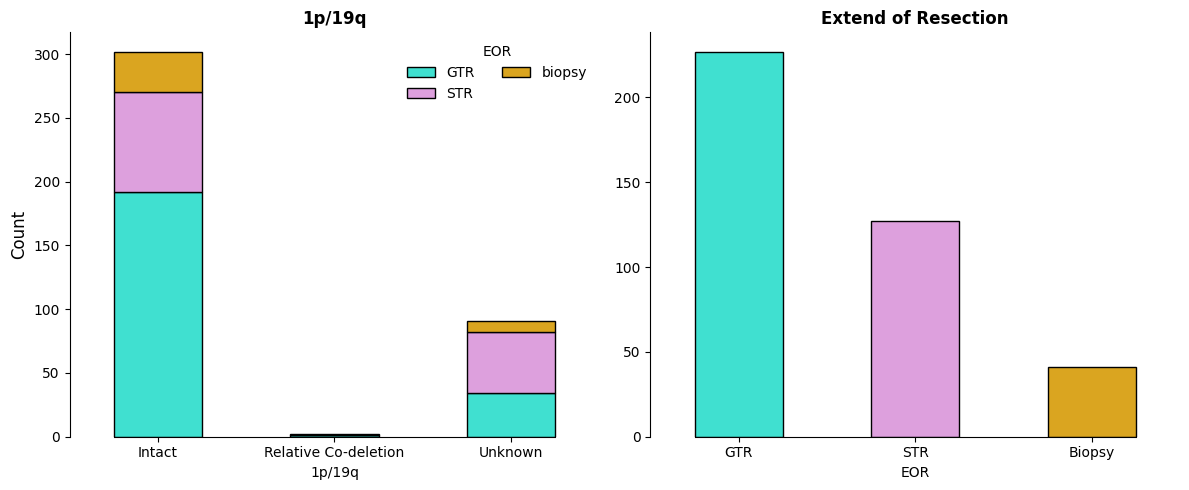

In [29]:
dt = TDstats.copy()
dt["1p/19q"] = dt["1p/19q"].fillna('unknown')
dt = dt.groupby(["1p/19q", "EOR"])["Sex"].count().unstack()
print(dt)
fig, ax = plt.subplots(1,2,figsize=(12,5))
dt.plot.bar(
    stacked=True,
    ax=ax[0],
    color=['turquoise', 'plum', 'goldenrod'], 
    edgecolor='black'  
)
ax[0].set_xticklabels(["Intact", "Relative Co-deletion", "Unknown"], fontsize=10, rotation=0)
ax[0].spines[["top", "right"]].set_visible(False)
ax[0].legend(frameon=False, ncols=2, title="EOR", fancybox=False, fontsize=10)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].set_title("1p/19q", fontsize=12, fontweight='bold')
ax[0].spines['bottom'].set_bounds(-0.25,2.25)

eor_counts = TDstats["EOR"].value_counts()
eor_counts.plot.bar(
    ax=ax[1],
    color=['turquoise', 'plum', 'goldenrod'],  # You can choose any colors you prefer
    edgecolor='black'  # Optional, adds borders to the bars
)

# Add labels and title
ax[1].spines[["top", "right"]].set_visible(False)
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(["GTR", "STR", "Biopsy"], rotation=0)
ax[1].set_title("Extend of Resection", fontsize=12, fontweight='bold')
ax[1].spines['bottom'].set_bounds(-0.25,2.25)

fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/1p19q-EOR.svg", dpi=300, format='svg')

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'plum', 'goldenrod']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(3,), dtype=object)
for i, D in enumerate(["GTR", "STR", "biopsy"]):
    diag = TDstats[TDstats["EOR"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])
    
    if i<2: # Delete the if clause if you want the multivariate test
        OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
        GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.60, 0.90, r"$\chi^2_{ GTR,STR} =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
    ax.text(t-2, -0.19, f"{nums[2][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[2]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.26,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/EOR_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')
plt.close(fig)

Biopsy prior to imaging
No     336
Yes     60
Name: count, dtype: int64


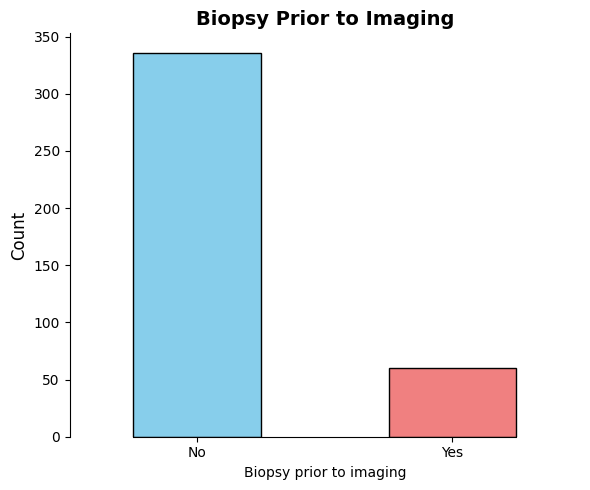

In [31]:
print(TDstats["Biopsy prior to imaging"].value_counts())
biopsy_counts = TDstats["Biopsy prior to imaging"].value_counts()

fig, ax = plt.subplots(figsize=(6,5))
biopsy_counts.plot.bar(
    ax=ax,
    color=['skyblue', 'lightcoral'],  
    edgecolor='black' 
)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([0,1])
ax.set_xticklabels(["No", "Yes"], rotation=0)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Biopsy Prior to Imaging", fontsize=14, fontweight='bold')
ax.spines['bottom'].set_bounds(-0.25,1.25)

fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/biopsy.svg", dpi=300, format='svg')

# We apply the filtering that we designed

In [32]:
figs_folder = f"Demographics-GBMWildtype"
os.makedirs("../Figures/TDMaps_Grade-IV/"+figs_folder, exist_ok=True)

TDstats = pd.read_csv(f"../Figures/TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv")
TDstats = TDstats.loc[TDstats["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
TDstats = TDstats.loc[TDstats["OS"].fillna('unknown')!='unknown']
TDstats = TDstats.loc[TDstats["MGMT status"].isin(["positive", "negative"])]
TDstats = TDstats.loc[TDstats["MGMT index"].fillna('unknown')!='unknown']
TDstats = TDstats.loc[TDstats["1p/19q"].fillna('unknown').isin(["intact", "unknown"])]
TDstats["1p/19q"] = TDstats["1p/19q"].fillna('unknown')

censored = (TDstats["1-dead 0-alive"]==0).sum()
all = TDstats["1-dead 0-alive"].value_counts().sum()
print("1 dead/0 alive: ", f"{all-censored}/{censored}", "\nTotal: ",all)
print(f"Precentage of censoring: {round(100*censored/all,2)}%")
TDstats.describe()

1 dead/0 alive:  209/138 
Total:  347
Precentage of censoring: 39.77%


,Age at MRI,WHO CNS Grade,MGMT index,1-dead 0-alive,OS,# Labels,Whole TDMap,Whole lesion TDMap,Core TDMap,Core lesion TDMap,Non-enhancing TDMap,Non-enhancing lesion TDMap,Enhancing TDMap,Enhancing lesion TDMap,Core+Enhancing TDMap,Core+Enhancing lesion TDMap
count,347.000000,347.0,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,336.000000,336.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,61.778098,4.0,6.463977,0.602305,462.884726,2.968300,109.738867,3.676271,125.524761,1.149144,106.874419,3.470078,100.316871,1.772677,109.755391,1.779444
std,11.997099,0.0,6.770025,0.490128,382.356057,0.175454,37.602570,1.847891,76.041073,0.994946,42.993708,1.843372,54.336132,1.191742,57.625719,1.197653
min,21.000000,4.0,0.000000,0.000000,6.000000,2.000000,10.326545,0.142366,0.000000,0.000000,6.590747,0.001976,0.058430,0.000067,0.058430,0.000067
25%,54.000000,4.0,0.000000,0.000000,183.000000,3.000000,91.478723,2.351701,69.264873,0.353845,81.246996,2.221612,62.592108,0.768645,71.394394,0.771605
50%,62.000000,4.0,3.000000,1.000000,363.000000,3.000000,109.495930,3.736985,125.746209,0.895873,105.763468,3.460460,96.622609,1.725475,108.668836,1.725487
75%,71.000000,4.0,14.000000,1.000000,625.500000,3.000000,131.784646,4.957435,172.231150,1.757872,132.705568,4.770658,130.005555,2.524061,142.563250,2.550051
max,94.000000,4.0,17.000000,1.000000,2144.000000,3.000000,247.648025,10.645649,543.595906,4.798378,255.663075,10.645649,342.948077,5.749730,342.948077,5.761265


### Sex

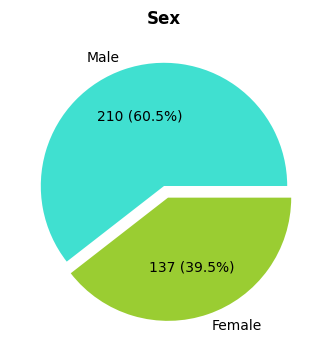

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
TDstats["Sex"].value_counts().plot.pie(labels=["Male", "Female"], ax=ax, explode=[0, 0.1], autopct=autopct_format(TDstats["Sex"].value_counts()), colors=['turquoise', 'yellowgreen'])
ax.set_title("Sex", fontweight='bold')
ax.set_ylabel("")
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/sex.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

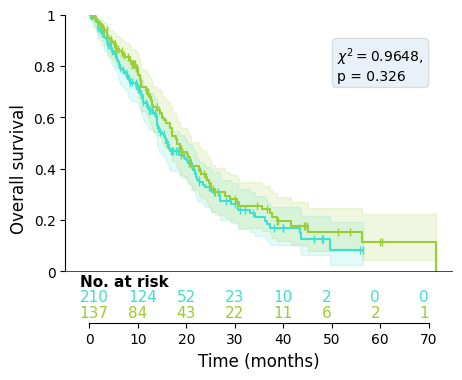

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'yellowgreen']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, S in enumerate(["M", "F"]):
    sex = TDstats[TDstats["Sex"]==S]
    mask = ~np.isnan(sex["1-dead 0-alive"]) & ~np.isnan(sex["OS"])
    sex = sex[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((sex["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                sex["1-dead 0-alive"]==1, sex["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in sex.loc[sex["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(sex["1-dead 0-alive"]==1, sex["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in sex["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/sex_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

### Age

/tmp/ipykernel_993335/1567635318.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)


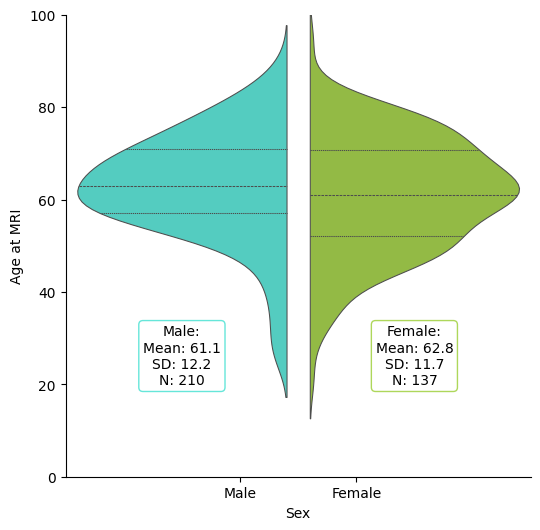

In [35]:
# Calculate statistics for each group
male_stats = TDstats[TDstats["Sex"] == "M"]["Age at MRI"].describe()
female_stats = TDstats[TDstats["Sex"] == "F"]["Age at MRI"].describe()

male_text = (f"Male:\n"
             f"Mean: {male_stats['mean']:.1f}\n"
             f"SD: {male_stats['std']:.1f}\n"
             f"N: {int(male_stats['count'])}")

female_text = (f"Female:\n"
               f"Mean: {female_stats['mean']:.1f}\n"
               f"SD: {female_stats['std']:.1f}\n"
               f"N: {int(female_stats['count'])}")

# Create the violin plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)

# Remove unnecessary spines
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylim([0, 100])
ax.set_ylabel("Age at MRI")
ax.set_xticks([0.25, 0.75], ["Male", "Female"])

# Add the text to the plot
ax.text(0, 20, male_text, fontsize=10, color='black', ha='center', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round', edgecolor="turquoise"))
ax.text(1, 20, female_text, fontsize=10, color='black', ha='center', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round', edgecolor="yellowgreen"))

# Save the figure
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/age-sex.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')


### MGMT Status

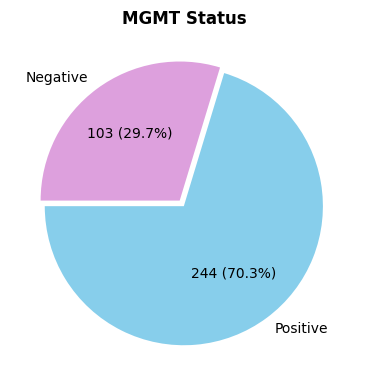

In [36]:
fig, ax = plt.subplots(1,1,figsize=(4, 4))
dt = TDstats["MGMT status"].value_counts()
color_types = ["skyblue", "plum"]
labels = ["Positive", "Negative"]

dt.plot.pie(
    ax=ax,
    labels=labels,
    autopct=autopct_format(dt),
    colors=color_types,
    explode=[0., 0.05],  
    startangle=180
)

ax.set_title("MGMT Status", fontweight='bold')
ax.set_ylabel("")
fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/diagnosis-MGMT.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

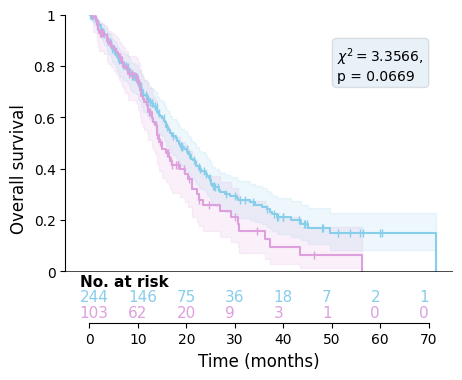

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ["skyblue", "plum"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["positive", "negative"]):
    diag = TDstats[TDstats["MGMT status"]==D]
    #mask = diag["1-dead 0-alive"]==1
    #diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMTstatus_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

### MGMT Index

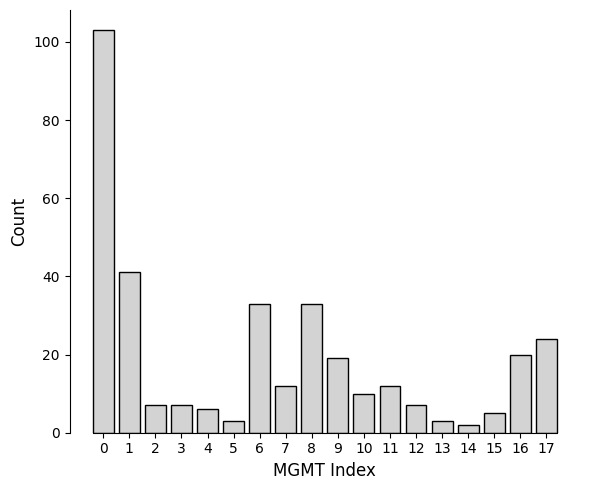

In [38]:
mgmt_index_counts = TDstats["MGMT index"].value_counts()
sorted_index = np.sort(mgmt_index_counts.index.to_numpy(dtype=int))

# Plot a barplot with the sorted order
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    sorted_index,
    mgmt_index_counts[np.argsort(mgmt_index_counts.index.to_numpy(dtype=int))],
    edgecolor="black",
    color='lightgray'
)
# Add titles and labels
ax.spines[["top","right"]].set_visible(False)
ax.set_xticks(sorted_index)
ax.set_xticklabels(sorted_index, rotation=0)
ax.set_xlabel('MGMT Index', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines['bottom'].set_bounds(-0.4,17.4)

# Display the plot
plt.tight_layout()  # Adjust layout for better display
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

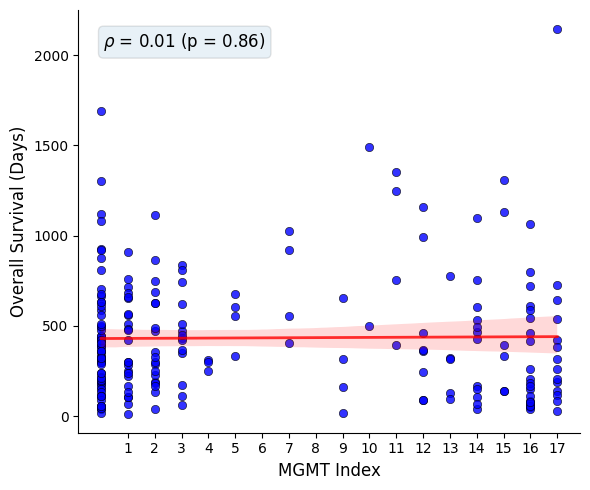

In [39]:
filtered_data = TDstats[TDstats["1-dead 0-alive"] == 1]  # Only consider status == 1

mgmt_index = filtered_data["MGMT index"]
os = filtered_data["OS"]
pearson_corr, p_value = pearsonr(mgmt_index, os)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    x=mgmt_index,
    y=os,
    ax=ax,
    color="blue",
    edgecolor="black",
    alpha=0.8
)

# Add the regression line
sns.regplot(
    x=mgmt_index,
    y=os,
    ax=ax,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

# Annotate Pearson correlation
ax.text(
    0.05, 0.95,
    r'$\rho$'+f" = {pearson_corr:.2f} (p = {p_value:.2g})",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.1), 
    color="red" if p_value<=0.05 else "black"
)

# Customize the plot
ax.set_xticks(sorted_index[1:])
ax.set_xlabel("MGMT Index", fontsize=12)
ax.set_ylabel("Overall Survival (Days)", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

# Show the plot
plt.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index_OS.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

# 1p/19q and EOR

EOR      GTR  STR  biopsy
1p/19q                   
intact   176   61      28
unknown   32   43       7


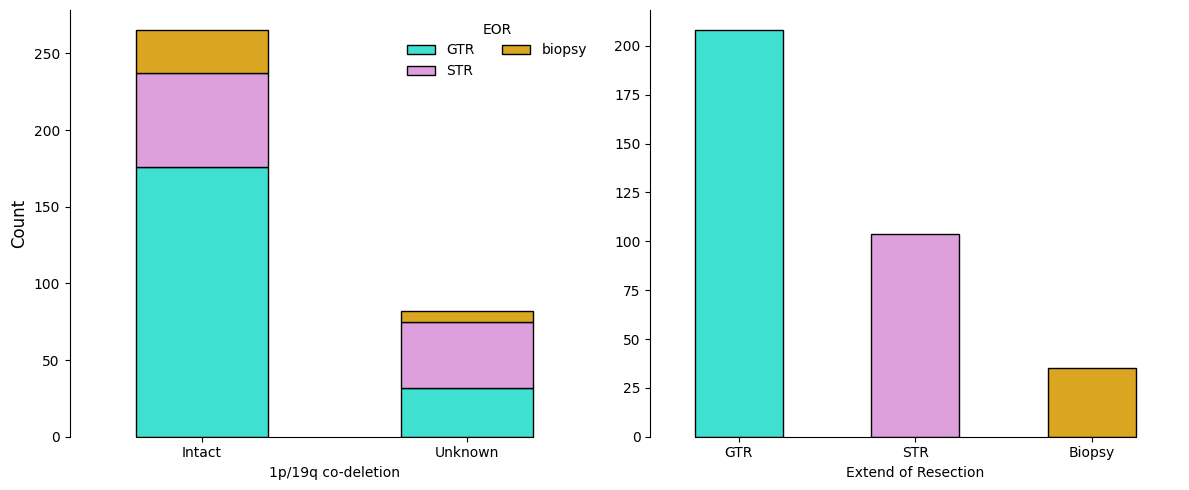

In [40]:
dt = TDstats.copy()
dt = dt.groupby(["1p/19q", "EOR"])["Sex"].count().unstack()
print(dt)
fig, ax = plt.subplots(1,2,figsize=(12,5))
dt.plot.bar(
    stacked=True,
    ax=ax[0],
    color=['turquoise', 'plum', 'goldenrod'], 
    edgecolor='black'  
)
ax[0].set_xticklabels(["Intact", "Unknown"], fontsize=10, rotation=0)
ax[0].spines[["top", "right"]].set_visible(False)
ax[0].legend(frameon=False, ncols=2, title="EOR", fancybox=False, fontsize=10)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].spines['bottom'].set_bounds(-0.25,1.25)
ax[0].set_xlabel("1p/19q co-deletion")

eor_counts = TDstats["EOR"].value_counts()
eor_counts.plot.bar(
    ax=ax[1],
    color=['turquoise', 'plum', 'goldenrod'],  # You can choose any colors you prefer
    edgecolor='black'  # Optional, adds borders to the bars
)

# Add labels and title
ax[1].spines[["top", "right"]].set_visible(False)
ax[1].set_xlabel("Extend of Resection")
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(["GTR", "STR", "Biopsy"], rotation=0)
ax[1].spines['bottom'].set_bounds(-0.25,2.25)

fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/1p19q-EOR.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

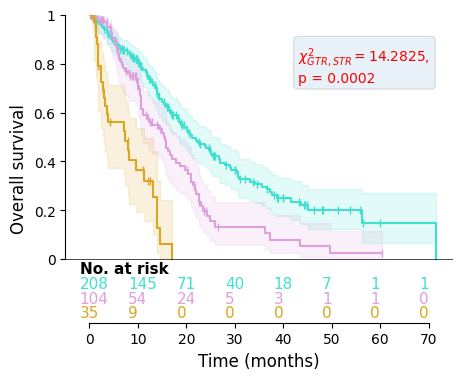

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'plum', 'goldenrod']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(3,), dtype=object)
for i, D in enumerate(["GTR", "STR", "biopsy"]):
    diag = TDstats[TDstats["EOR"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])
    
    if i<2: # Delete the if clause if you want the multivariate test
        OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
        GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.60, 0.90, r"$\chi^2_{ GTR,STR} =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
    ax.text(t-2, -0.19, f"{nums[2][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[2]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.26,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/EOR_KM.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

### Biopsy prior to surgery

Biopsy prior to imaging
No     298
Yes     49
Name: count, dtype: int64


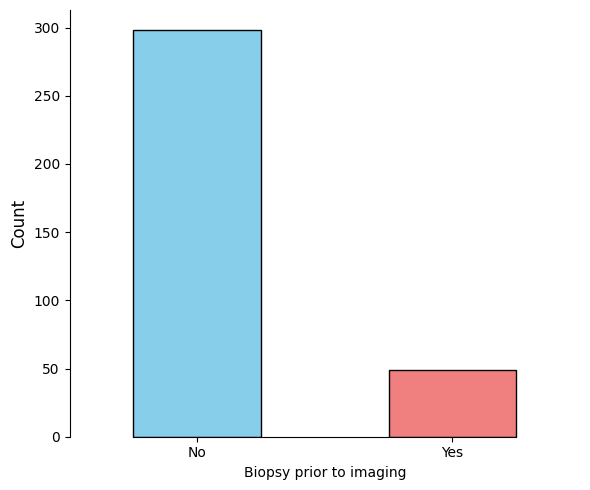

In [42]:
print(TDstats["Biopsy prior to imaging"].value_counts())
biopsy_counts = TDstats["Biopsy prior to imaging"].value_counts()

fig, ax = plt.subplots(figsize=(6,5))
biopsy_counts.plot.bar(
    ax=ax,
    color=['skyblue', 'lightcoral'],  
    edgecolor='black' 
)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([0,1])
ax.set_xticklabels(["No", "Yes"], rotation=0)
ax.set_ylabel("Count", fontsize=12)
ax.spines['bottom'].set_bounds(-0.25,1.25)

fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/biopsy.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')

### Tract Density Indices

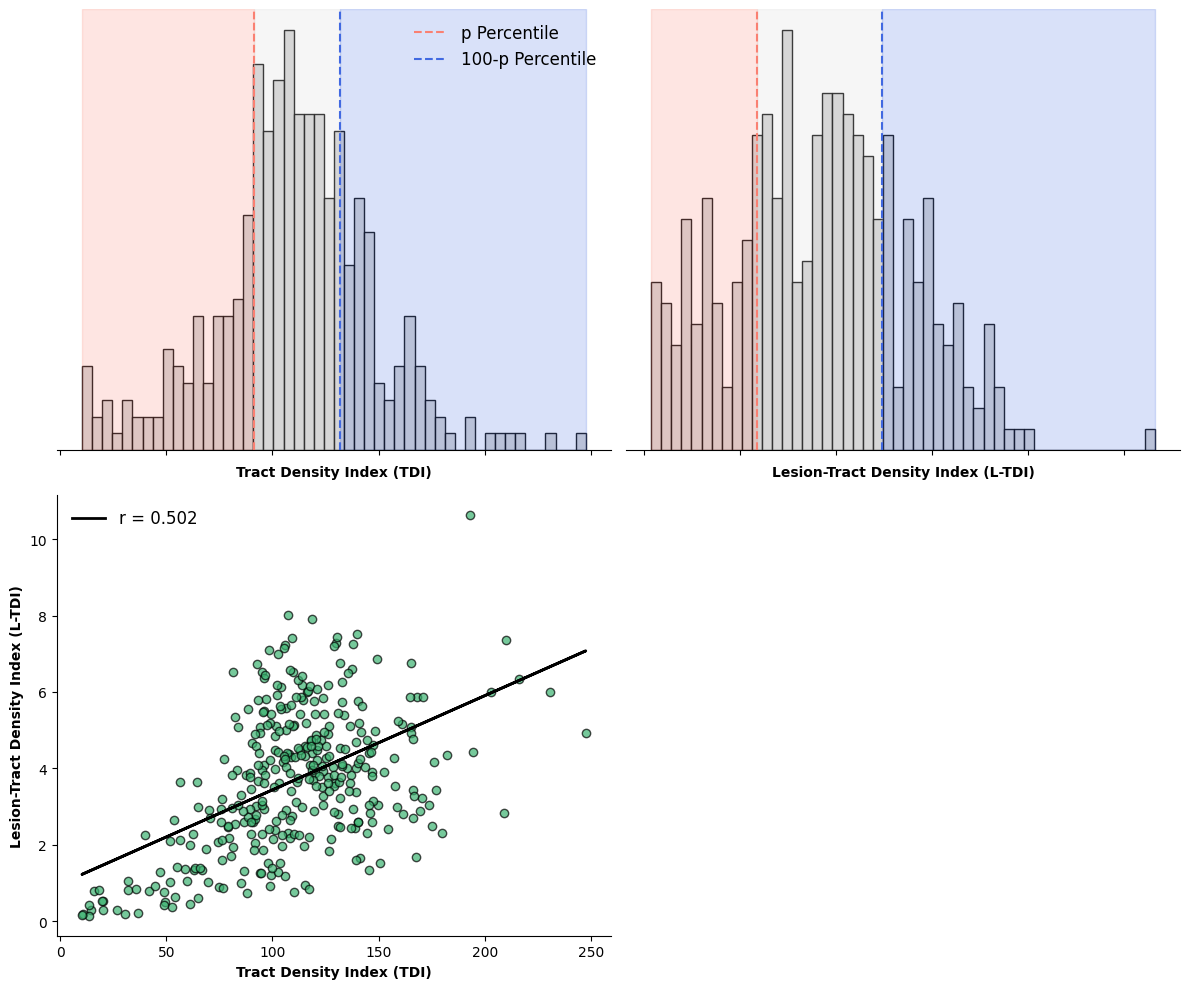

In [70]:
# Prepare the figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1]})

# Prepare data for percentile lines
tdi_25, tdi_75 = TDstats["Whole TDMap"].quantile(0.25), TDstats["Whole TDMap"].quantile(0.75)
ltdi_25, ltdi_75 = TDstats["Whole lesion TDMap"].quantile(0.25), TDstats["Whole lesion TDMap"].quantile(0.75)

# Histogram for "Whole TDMap"
tdi = TDstats["Whole TDMap"].dropna()
ax[0, 0].hist(tdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 0].axvline(tdi_25, color='salmon', linestyle="--", linewidth=1.5, label="p Percentile")
ax[0, 0].axvline(tdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="100-p Percentile")
ax[0, 0].fill_betweenx([0, 1], tdi.min(), tdi_25, color="salmon", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_25, tdi_75, color="lightgray", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_75, tdi.max(), color="royalblue", alpha=0.2, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[0, 0].spines[["top", "right", "left"]].set_visible(False)
ax[0, 0].set_yticks([])
ax[0, 0].set_xticklabels([])
ax[0, 0].legend(loc="upper right", fontsize=12, frameon=False)

# Histogram for "Whole lesion TDMap"
ltdi = TDstats["Whole lesion TDMap"].dropna()
ax[0, 1].hist(ltdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 1].axvline(ltdi_25, color='salmon', linestyle="--", linewidth=1.5, label="25th Percentile")
ax[0, 1].axvline(ltdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="75th Percentile")
ax[0, 1].fill_betweenx([0, 1], ltdi.min(), ltdi_25, color="salmon", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].fill_betweenx([0, 1], ltdi_25, ltdi_75, color="lightgray", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].fill_betweenx([0, 1], ltdi_75, ltdi.max(), color="royalblue", alpha=0.2, transform=ax[0, 1].get_xaxis_transform())
ax[0, 1].set_xlabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[0, 1].spines[["top", "right", "left"]].set_visible(False)
ax[0, 1].set_yticks([])
ax[0, 1].set_xticklabels([])

# Scatter plot for the relationship between the two variables
ax[1, 0].scatter(
    TDstats["Whole TDMap"], 
    TDstats["Whole lesion TDMap"], 
    alpha=0.7, color="mediumseagreen", edgecolor="black"
)
ax[1, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[1, 0].set_ylabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[1, 0].spines[["top", "right"]].set_visible(False)
#ax[1, 0].set_xticklabels([])
#ax[1, 0].set_yticklabels([])

x = TDstats["Whole TDMap"].dropna()
y = TDstats["Whole lesion TDMap"].dropna()
slope, intercept, r_value, _, _ = linregress(x, y)
ax[1, 0].plot(x, slope * x + intercept, color="black", linestyle="-", label=f"r = {r_value:.3f}", linewidth=2)
ax[1, 0].legend(loc="upper left", fontsize=12, frameon=False)

# Hide empty subplot (bottom right)
ax[1, 1].axis("off")

# Adjust layout
fig.tight_layout()
fig.savefig(f"../Figures/TDMaps_Grade-IV/{figs_folder}/TDIndices.svg", dpi=300, format='svg', transparent=True, bbox_inches='tight')